
## 0. Content
***

**Milestone 3**
1. [Reminder: Definition of Prediction Problem](#c.1)
2. [Training and Testing Datasets Loading](#c.2)
3. [Definition of functions](#c.3)
4. [Proposed Workflow](#c.4)
5. [Selection of Initial Model](#c.5)
6. [Hyperparameters Tunning](#c.6)
7. [Performance Evaluation: Tuned Model 1](#c.7)
8. [Explanatory Variables Importance and Selection](#c.8)
9. [Hyperparameters Tunning after Variables Selection](#c.9)
10. [Performance Evaluation: Tuned Model after Variables Selection](#c.10)
11. [Comparison of Tuned Models](#c.11)
12. [References](#c.12)

<div class="alert alert-block alert-info"> <b>NOTE</b> For optimal execution of this notebook, please ensure that you run all cells in sequence. </div>

# Milestone 3

***
## 1. Reminder Definition of Prediction Problem <a id='c.1'></a>
***
The aim is to predict drought categories at the county level in the United States and at different periods of time as a function of weather and soil conditions. These categories align with the classifications established by the [US Drought Monitor](https://droughtmonitor.unl.edu/CurrentMap.aspx) and include No Drought and five additional categories as outlined below:

![Drought Categories](img/D_categories.png)

**Important: Geographic and Time Constraints**

* To address the challenges associated with a large dataset, which can lead to extended training times and high resource consumption for the model trainings, we decided to narrow our focus to the [Mountain West States](https://en.wikipedia.org/wiki/Western_United_States) of the United States.
*  Likewise, the years included in each of the datasets are the followings:
    * Training: 2014 to 2018
    * Testing: 2019 & 2020


***
## 2. Training and Testing Datasets Loading <a id='c.2'></a>
***

In [5]:
# Importing necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import time

from sklearn.preprocessing import StandardScaler, label_binarize
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFECV
import joblib

pd.set_option('display.max_columns', None)

In [6]:
# Load Training and Testing datasets
data_dir = 'data'

# Define the list of datasets to be loaded
dataframes = ['train_TIME', 'test_TIME']

# Load the datasets
datasets = {}
for df_name in dataframes:
    file_name = f'{df_name}.csv'
    file_path = os.path.join(data_dir, file_name)
    datasets[df_name] = pd.read_csv(file_path)

# Access the datasets using their keys
train_df = datasets['train_TIME']
test_df = datasets['test_TIME']

# Change the data type of columns starting with "SQ" to uint8
for df in [train_df, test_df]:
    for column in df.columns:
        if column.startswith("SQ"):
            df[column] = df[column].astype("uint8")

In [7]:
# Display a detailed summary of the Training dataset
train_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160720 entries, 0 to 160719
Data columns (total 62 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   PRECTOT        160720 non-null  float64
 1   PS             160720 non-null  float64
 2   QV2M           160720 non-null  float64
 3   T2M            160720 non-null  float64
 4   T2MDEW         160720 non-null  float64
 5   T2MWET         160720 non-null  float64
 6   T2M_MAX        160720 non-null  float64
 7   T2M_MIN        160720 non-null  float64
 8   T2M_RANGE      160720 non-null  float64
 9   TS             160720 non-null  float64
 10  WS10M          160720 non-null  float64
 11  WS10M_MAX      160720 non-null  float64
 12  WS10M_MIN      160720 non-null  float64
 13  WS10M_RANGE    160720 non-null  float64
 14  WS50M          160720 non-null  float64
 15  WS50M_MAX      160720 non-null  float64
 16  WS50M_MIN      160720 non-null  float64
 17  WS50M_RANGE    160720 non-nul

In [8]:
# Display a detailed summary of the Testing dataset
test_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29400 entries, 0 to 29399
Data columns (total 62 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PRECTOT        29400 non-null  float64
 1   PS             29400 non-null  float64
 2   QV2M           29400 non-null  float64
 3   T2M            29400 non-null  float64
 4   T2MDEW         29400 non-null  float64
 5   T2MWET         29400 non-null  float64
 6   T2M_MAX        29400 non-null  float64
 7   T2M_MIN        29400 non-null  float64
 8   T2M_RANGE      29400 non-null  float64
 9   TS             29400 non-null  float64
 10  WS10M          29400 non-null  float64
 11  WS10M_MAX      29400 non-null  float64
 12  WS10M_MIN      29400 non-null  float64
 13  WS10M_RANGE    29400 non-null  float64
 14  WS50M          29400 non-null  float64
 15  WS50M_MAX      29400 non-null  float64
 16  WS50M_MIN      29400 non-null  float64
 17  WS50M_RANGE    29400 non-null  float64
 18  score 

In [9]:
# Percentage of the Training-Testing split
total_rows = len(train_df)+ len(test_df)

train_percentage = (len(train_df) / total_rows) * 100
test_percentage = (len(test_df) / total_rows) * 100

print(f"Training dataset percentage: {train_percentage:.2f}%")
print(f"Testing dataset percentage {test_percentage:.2f}%")

Training dataset percentage: 84.54%
Testing dataset percentage 15.46%


In [10]:
# Division Explanatory Variables and Target
X_train = train_df.drop(columns='score')
y_train = train_df['score']
X_test = test_df.drop(columns='score')
y_test = test_df['score']

It is important to clarify that Random Forest does not require Standardization. This is because it is a tree-based model and does not rely on gradient descent optimization (Filho, 2023). In this milestone, the Standardization is only performed to facilitate later the application Oversampling Techniques as SMOTE.

In [12]:
# Create a StandardScaler object to standardize the data.
scaler = StandardScaler()
# Fit the scaler to the training data to compute mean and standard deviation.
scaler.fit(X_train)
# Transform the training data using the computed mean and standard deviation.
scaled_X_train = scaler.transform(X_train)
# Transform the test data using the same scaler.
scaled_X_test = scaler.transform(X_test)

***
## 3. Definition of functions <a id='c.3'></a>
***

To minimize code redundancy, we created four functions:

* One for evaluating model performance and plotting the confusion matrix
* The second for computing the f1_macro metric
* The third to plot the Out-of-Bag (OOB) error rate based Vs. n_estimators in a Random Forest classifier
* The last for plotting precision-recall curves

In [13]:
# Test Model's Performance
def evaluate_model_performance(y_true, y_pred):
    """
    Evaluate the performance of the classification model and plot a confusion matrix.

    Parameters:
    - y_true: true labels for the data
    - y_pred: predicted labels from the model
    """
    # Define the class labels
    
    # Generate a classification report
    print(classification_report(y_true, y_pred, target_names=['No Drought', 'D0','D1','D2','D3','D4']))

    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create a ConfusionMatrixDisplay object and plot the confusion matrix
    sns.set(style='dark')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Drought', 'D0','D1','D2','D3','D4'])
    plt.figure(figsize=(4, 4))
    disp.plot()

In [15]:
# Calculate f1_macro score
def f1_score_macro_metric(y_true, y_pred):
    """
    Compute the macro-averaged F1 score for multiclass classification.
    
    Parameters:
    - y_true: true labels for the data
    - y_pred: predicted labels from the model
    """
    return f1_score(y_true, y_pred, average='macro')

In [16]:
# Plot OOB score Vs n_estimators
def plot_oob_error_vs_n_estimators(step, rf_model, X_train, y_train):
    """
    Plot the Out-of-Bag (OOB) error rate based on f1_macro score Vs. the number of trees (n_estimators) in a Random Forest model.

    Parameters:
        step (int): The step size for the range of n_estimators values to explore.
        rf_model (RandomForestClassifier): The Random Forest model to use for OOB error calculation.
        X_train (array-like): The training data.
        y_train (array-like): Labels of training data
      
    """
    # Initialize a list to store OOB error rates for different n_estimators settings.
    error_rate = []

    # Define the range of `n_estimators` values to explore.
    min_estimators = 100
    max_estimators = 1500

    # Iterate over a range of "n_estimators" values to build Random Forest models.
    for i in range(min_estimators, max_estimators + 1, step):
        # Set the 'n_estimators' parameter for the given rf_model.
        rf_model.set_params(n_estimators=i, verbose=1)

        # Fit the classifier on the training data.
        rf_model.fit(X_train, y_train)

        # Record the OOB error rate for the current "n_estimators=i" setting.
        oob_error = 1 - rf_model.oob_score_
        error_rate.append(oob_error)

    # Generate a plot showing the "n_estimators" Vs. "OOB error rate"
    sns.set_style("darkgrid")
    plt.plot(range(min_estimators, max_estimators + 1, step), error_rate, label="OOB error rate")
    
    plt.ylim(min(error_rate)-0.02,max(error_rate)+0.02) 
    plt.xlim(min_estimators, max_estimators)
    plt.xlabel("n_estimators")
    plt.ylabel("OOB error rate (based on f1_macro score)")
    plt.legend(loc="upper right")
    plt.show()

In [17]:
# Plot Precision Recall curves per class
# Based on https://stackoverflow.com/questions/56090541/how-to-plot-precision-and-recall-of-multiclass-classifier
# Additional Resources: https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py
def plot_precision_recall_curves(model, X_test, y_test):
    """
    Generate and plot a Precision-Recall curve for a multi-class classification model.

    Parameters:
    model (estimator): The classification model for which the Precision-Recall curve is generated.
    X_test (array-like): The feature matrix of the test data.
    y_test (array-like): The true labels of the test data.
    """

    # Binarize the true labels for multi-label settings
    y_test = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5])
    n_classes = y_test.shape[1]

    # Calculate the decision function scores
    y_score = model.predict_proba(X_test)

    # Initialize dictionaries to store precision and recall values
    precision = dict()
    recall = dict()

    # Calculate precision and recall for each class
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])
        plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(['No Drought', 'D0', 'D1', 'D2', 'D3', 'D4'][i]))

    # Set axis labels and legend
    sns.set_style("darkgrid")
    sns.set_style("darkgrid")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="best")
    plt.title("Precision-Recall curve per class")
    plt.show()

***
## 4.  Proposed Workflow <a id='c.4'></a>
***
To be more clear, the diagram below presents the proposed workflow for this milestone:

![Workflow_RF_mod](img/Workflow_RF_mod.jpg)

Starting with the Proposed Workfow, the table below outlines the parameters **shared** among the Model 1 and Model 2 with their respective explanations based on the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html):

| Parameter Name             | Selected Value       | Explanation                                                                                                           |
|---------------------------|-----------------------|-----------------------------------------------------------------------------------------------------------------------|
| `n_estimators`             | 500                   | 500 estimators were selected as a starting point to assess execution speed of the models, a middle-ground choice. |
| `criterion`                | default="gini"       | The splitting quality is based on the Gini impurity.                                                                |
| `max_depth`               | default=None         | No limit is set on the depth of the estimators, as the primary focus is on assessing model execution times.      |
| `min_samples_split` | default=2             | The default value specifies that a minimum of 2 samples is required to split an internal node.                  |
| `min_samples_leaf`   | default=1             | The default value requires a minimum of 1 sample to be at a leaf node.                                           |
| `min_weight_fraction_leaf` | default=0.0    | All samples are assigned equal weight.                                                                             |
| `max_features`            | default="sqrt"      | The default value for `max_features` is chosen as a baseline; it's recommended for classification and will be fine-tuned later. |
| `max_leaf_nodes`       | default=None         | The number of leaf nodes is not limited.                                                                          |
| `min_impurity_decrease` | default=0.0    | In the default setting, there is no constraint on the minimum impurity decrease.                                                                  |
| `bootstrap`                | default=True        | Bootstrap samples are used when building trees.                                                                  |
| `oob_score`              | callable→f1_score_macro_metric | By default, accuracy_score is used, but f1_macro is chosen due to dataset imbalance. |
| `n_jobs`                    | -1                       | `n_jobs` is set to -1, utilizing all available processors.                                                           |
| `random_state`           | 44                     | The `random_state` is set to 44 to ensure reproducibility.                                                         |
| `verbose`                  | default=0            | Verbosity is set to its default value (0) since it's not required in the initial stage.                               |
| `warm_start`           | default=False       | `warm_start` is kept at its default value as it's the first fit of each model.                                 |
| `ccp_alpha`                | default=0.0        | No pruning is performed.                                                                                                |
| `max_samples`          | default=None       | The default value indicates that all samples (X.shape[0]) are used to train each estimator. |


***
## 5.  Selection of Initial Model <a id='c.5'></a>
***
Similar to what was presented in the previous milestone with Logistic Regression, we started our exploration by evaluating two Random Forest Classifiers, each tackling class imbalance differently. Initially, we approached it at the model-level using the `class_weight` parameter. Then, we addressed it at the data-level by employing the Synthetic Minority Oversampling Technique (SMOTE).

**Note**: We conducted testing on the [BalancedRandomForestClassifier](https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.BalancedRandomForestClassifier.html) from the imbalanced-learn library and observed that its performance closely matched that of the RandomForestClassifier from sklearn when using the class_weight parameter. Consequently, we continued our work with the sklearn algorithm.

### 5.1  Managing class imbalance with Model Weights
The `class_weight` default value is None, which assumes that all classes are supposed to have weight one. Consequently, it was modified as follows:

| Parameter Name  | Selected Value | Explanation                                             |
|------------------|-----------------|---------------------------------------------------------|
| **`class_weight`** | balanced       | We set it to 'balanced' to modify the weights inversely proportional to the class frequencies in the input data, using the formula: `n_samples / (n_classes * np.bincount(y))`, as outlined in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)|

**Result**: The model executed in under 1 minute, with an OOB error of 0.2006 using the f1_macro metric. During this initial assessment, our main objective was to evaluate the model's speed since it will undergo multiple runs for further fine-tuning. Achieving an outstanding score was not our primary goal at this stage.

In [18]:
# Model 1: Addressing Class Imbalance with Model Weights
start = time.time()
clf1 = RandomForestClassifier(n_estimators= 500, 
                              max_features= 'sqrt',
                              class_weight= 'balanced',
                              oob_score= f1_score_macro_metric,
                              n_jobs= -1,
                              random_state= 44)
clf1.fit(X_train, y_train)
end = time.time()
joblib.dump(clf1, 'model1_RF_TIME.pkl')

['model1_RF_TIME.pkl']

In [19]:
# Performance M1
print('OOB error clf1: ', round(1-clf1.oob_score_,4))
y_pred_clf1= clf1.predict(X_test)
print('f1_macro: ', f1_score(y_test, y_pred_clf1, average="macro"))

OOB error clf1:  0.2649
f1_macro:  0.24767949091669847


### 5.2  Managing class imbalance with SMOTE
This time the default value for the `class_weight` parameter was left, but same as in the previous milstone, synthetic instances based on existing examples were created. This approach is known as the Synthetic Minority Oversampling Technique (SMOTE). Specifically:

"SMOTE first selects a minority class instance at random and finds its k nearest minority class neighbors. The synthetic instance is then created by choosing one of the k nearest neighbors b at random and connecting a and b to form a line segment in the feature space. The synthetic instances are generated as a convex combination of the two chosen instances a and b" (He & Ma, 2013)

In [15]:
# Oversampling dataset with SMOTE
# https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
sm = SMOTE(random_state=44)
smote_X_train, smote_y_train = sm.fit_resample(scaled_X_train, y_train)

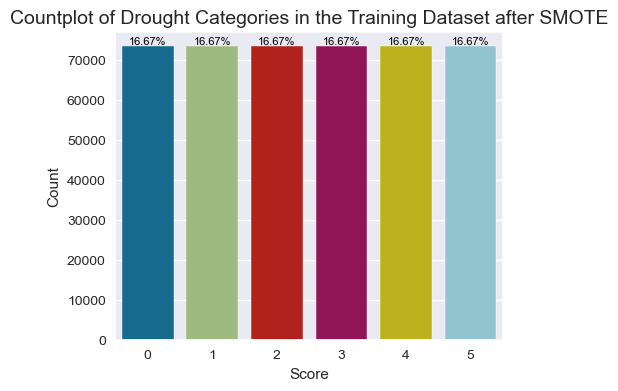

In [16]:
# Create a countplot to display the new distribution after SMOTE
# Set Seaborn style to "dark"
sns.set_style("darkgrid")

plt.figure(figsize=(5,4))
ax = sns.countplot(x=smote_y_train)
ax.set_title('Countplot of Drought Categories in the Training Dataset after SMOTE', fontsize=14) 

# Set the axis labels
ax.set_xlabel('Score')
ax.set_ylabel('Count')

# Annotate each bar with the count
for p in ax.patches:
    height = p.get_height()
    percentage = (height / len(smote_y_train)) * 100
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2., height + 500), ha='center', fontsize=8, color='black')

**Result**: This time, the model took approximately 4 minutes to complete, with an OOB error based on f1_macro score of 0.0448. Although it exhibited lower error, it required approximately four times the runtime of the previous model. This could potentially lead to significant time overhead when fine-tuning parameters, which often involves multiple iterations

In [21]:
# Model 2.1: Addressing Class Imbalance with SMOTE
start = time.time()
clf2_1 = RandomForestClassifier(n_estimators= 500, 
                              max_features= 'sqrt',
                              oob_score= f1_score_macro_metric,
                              n_jobs= -1,
                              random_state= 44)
clf2_1.fit(smote_X_train, smote_y_train)
end = time.time()
print('Execution time for Training clf2_1:', end - start, "seconds")
joblib.dump(clf2_1, 'model2_1_RF_TIME.pkl')

Execution time for Training clf2_1: 591.4293842315674 seconds


['model2_1_RF_TIME.pkl']

In [23]:
# Performance M2.1
print('OOB error clf2_1: ', round(1-clf2_1.oob_score_,4))
y_pred_clf2_1= clf2_1.predict(X_test)
print('f1_macro: ', f1_score(y_test, y_pred_clf2_1, average="macro"))

OOB error clf2_1:  0.0682
f1_macro:  0.11698362463432425


### 5.3  Managing class imbalance with RandomUnderSampler 

In [24]:
# Undersampling dataset with RandomUnderSampler
rus = RandomUnderSampler(random_state=44)
rus_X_train, rus_y_train = rus.fit_resample(scaled_X_train, y_train)

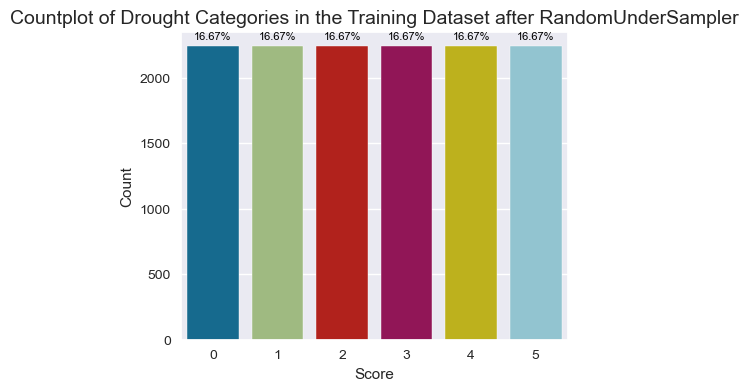

In [27]:
# Create a countplot to display the new distribution after RandomUnderSampler
# Set Seaborn style to "dark"
sns.set_style("darkgrid")

plt.figure(figsize=(5,4))
ax = sns.countplot(x=rus_y_train)
ax.set_title('Countplot of Drought Categories in the Training Dataset after RandomUnderSampler', fontsize=14) 

# Set the axis labels
ax.set_xlabel('Score')
ax.set_ylabel('Count')

# Annotate each bar with the count
for p in ax.patches:
    height = p.get_height()
    percentage = (height / len(rus_y_train)) * 100
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2., height + 50), ha='center', fontsize=8, color='black')

In [28]:
# Model 2.2: Addressing Class Imbalance with RandomUnderSampler
start = time.time()
clf2_2 = RandomForestClassifier(n_estimators= 500, 
                              max_features= 'sqrt',
                              oob_score= f1_score_macro_metric,
                              n_jobs= -1,
                              random_state= 44)
clf2_2.fit(rus_X_train, rus_y_train)
end = time.time()

print('Execution time for Training clf2_2:', end - start, "seconds")
joblib.dump(clf2_2, 'model2_2_RF_TIME.pkl')

Execution time for Training clf2_2: 13.077004432678223 seconds


['model2_2_RF_TIME.pkl']

In [30]:
# Performance M2.2
print('OOB error clf2_2: ', round(1-clf2_2.oob_score_,4))
y_pred_clf2_2= clf2_2.predict(X_test)
print('f1_macro: ', f1_score(y_test, y_pred_clf2_2, average="macro"))

OOB error clf2_2:  0.4505
f1_macro:  0.10319706090875704


***
## 6. Hyperparameters Tunning <a id='c.6'></a>
***
Taking into account the excecution speed,  we chose to further tune the first classifier, which addressed the class imbalance with the model's `class_weight` parameter.

The primary hyperparameters to optimize in a Random Forest Classifier are:

1. `n_estimators`: This parameter corresponds to the number of trees in the forest.
2. `max_features`: It is associated with the number of features considered when searching for the best split.
    * It plays a crucial role in guiding the model on how to select features for each tree. The available assignment methods include None, log, sqrt, as well as int and float values. When set to None, the model will consider all available features that are relevant to the tree's decision-making process. As for log or sqrt, the model will compute the logarithm or square root of the total number of features and use that value as the maximum number of features for a tree. Using an integer value will specify a fixed number of features to be considered by each tree while setting it as a float indicates a percentage of features relative to the total number of features. 
    * Selecting the optimal value for `max_features` involves a trade-off between model performance and training speed. Increasing the value may not always guarantee better performance, as it can reduce the diversity of individual trees. However, it can lead to more robust models. On the flip side, higher values can significantly slow down the training process (Srivastava, 2023)

To fine-tune these hyperparameters, we followed this methodology:

1. Initially, we trained the selected model multiple times, varying the `n_estimators` values. Specifically, we explored a range of values from 100 to 1500 in steps of 100. We then plotted the OOB score based on the f1_macro metric for each value. This plot allowed us to identify the initial n_estimators that resulted in a stabilized OOB error, rather than minimizing it.

2. With the chosen n_estimators value, we conducted a Grid Search to determine the optimal value for the `max_features` hyperparameter. We tested five different values (0.1, 0.3, 0.5, 0.7, 0.9). We selected the value with the highest mean f1_macro score and the lowest standard deviation.

3. As a double-check, we repeated the first step with the selected max_features value to verify if the previously chosen `n_estimators` value remained a suitable option.

### 6.1 First Step: Intial Calibration `n_estimators`

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   27.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   54.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   48.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done 4

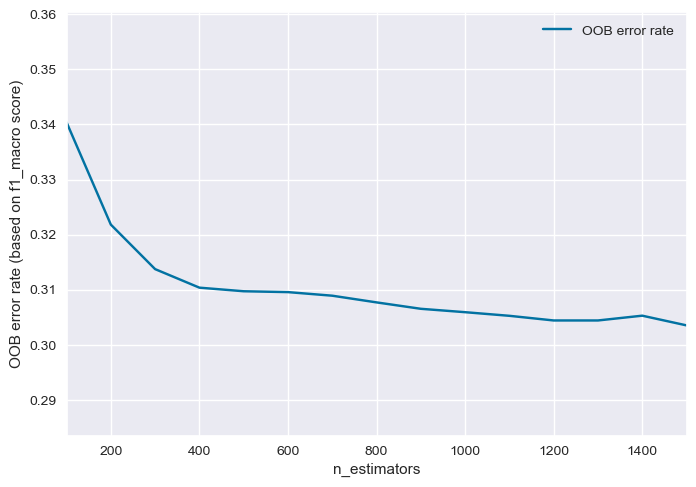

In [31]:
# n_estimators First Tunning
plot_oob_error_vs_n_estimators(step=100, rf_model=clf1, X_train=X_train, y_train=y_train)

**Result Step 1**: After analyzing the plot, the value of **800** for `n_estimators` was chosen, as it stabilizes the OOB error.

### 6.2  Second Step: Calibration `max_features`

In [20]:
# CV Methodology
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.85 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]
            
b_cv = BlockingTimeSeriesSplit(n_splits=5)
b_cv_idx = b_cv.split(scaled_X_train, y_train)
for train_idx, val_idx in b_cv_idx:
    print(len(train_idx), len(val_idx))

27322 4822
27322 4822
27322 4822
27322 4822
27322 4822


In [21]:
# max_features Tunning
# Define a grid of values to explore for the 'max_features' hyperparameter.
grid = {
    'max_features': [0.1, 0.3, 0.5, 0.7, 0.9]
}

# Create a base Random Forest model for tuning based on the selected n_estimators
clf1_t1  = RandomForestClassifier( n_estimators=800,
                                   max_features='sqrt',
                                   class_weight='balanced',
                                   n_jobs=-1,
                                   random_state=44)

start = time.time()
# Create a GridSearchCV object to explore hyperparameters.
grid_clf1 = GridSearchCV( estimator= clf1_t1,
                            param_grid= grid,
                            scoring='f1_macro',
                            cv= b_cv,
                            verbose=5,
                            return_train_score=True)

# Fit the grid search to the training data.
grid_clf1.fit(X_train, y_train)
end = time.time()
print("Execution time for Grid Search 1:", end - start, "seconds")
joblib.dump(grid_clf1, 'grid_RF_TIME_b_cv.pkl')

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END max_features=0.1;, score=(train=1.000, test=0.230) total time= 1.6min
[CV 2/5] END max_features=0.1;, score=(train=1.000, test=0.298) total time= 1.4min
[CV 3/5] END max_features=0.1;, score=(train=1.000, test=0.350) total time= 1.5min
[CV 4/5] END max_features=0.1;, score=(train=1.000, test=0.220) total time= 1.5min
[CV 5/5] END max_features=0.1;, score=(train=1.000, test=0.398) total time= 1.5min
[CV 1/5] END max_features=0.3;, score=(train=1.000, test=0.318) total time= 2.8min
[CV 2/5] END max_features=0.3;, score=(train=1.000, test=0.313) total time= 3.0min
[CV 3/5] END max_features=0.3;, score=(train=1.000, test=0.438) total time= 1.8min
[CV 4/5] END max_features=0.3;, score=(train=1.000, test=0.426) total time= 1.9min
[CV 5/5] END max_features=0.3;, score=(train=1.000, test=0.470) total time= 2.0min
[CV 1/5] END max_features=0.5;, score=(train=1.000, test=0.355) total time= 3.1min
[CV 2/5] END max_features=0

['grid_RF_TIME_b_cv.pkl']

In [22]:
# DataFrame to store cross-validation results.
results_grid_clf1 = pd.DataFrame()
results_grid_clf1 = pd.DataFrame(grid_clf1.cv_results_)[["params", "mean_test_score", "std_test_score"]]
results_grid_clf1

,params,mean_test_score,std_test_score
0,{'max_features': 0.1},0.299356,0.068554
1,{'max_features': 0.3},0.393056,0.065001
2,{'max_features': 0.5},0.439887,0.069059
3,{'max_features': 0.7},0.468055,0.075284
4,{'max_features': 0.9},0.489298,0.089094


**Result Step 2**: The value of **0.7** `max_features` was selected as it achieves the largest average score.

### 6.3  Third Step: Final Calibration `n_estimators`

In [23]:
# n_estimators Second Tunning
clf1_t2  = RandomForestClassifier( max_features= 0.9,
                                   class_weight='balanced',
                                   oob_score= f1_score_macro_metric,
                                   n_jobs=-1,
                                   random_state=44)

plot_oob_error_vs_n_estimators(step=100, rf_model=clf1_t2, X_train=X_train, y_train=y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.4min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 15.4min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 27.2min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 4

KeyboardInterrupt: 

**Result Step 3**: The value of **800** `n_estimators` continued to be an stable value

***
## 7. Performance Evaluation: Tuned Model 1 <a id='c.7'></a>
***
Below, the classification report and the confusion matrix is displayed for the tuned model. 

**Result**: Compared to the results achieved with Logistic Regression, this model has better performance across all metrics, not only for the majority class but also for the minority classes. Nevertheless, the performance is not optimal. The f1_macro score obtained is 0.24, with individual f1_scores exceeding 0.5 only for the majority class. Conversely, the minority classes display values below 0.25. This indicate a high presence of false positives and false negatives, highlighting the model's difficulty in correctly classifying relevant instances across all classes.

In [ ]:
# Tuned Model 1
clf1_t3= RandomForestClassifier(n_estimators= 800,
                                max_features= 0.7,
                                class_weight='balanced',
                                n_jobs=-1,
                                random_state=44)
clf1_t3.fit(X_train, y_train)

In [ ]:
# Performance Evaluation Tuned Model 1
y_pred_clf1_t3= clf1_t3.predict(X_test)
evaluate_model_performance(y_test, y_pred_clf1_t3)

***
## 8. Explanatory Variables Importance and Selection <a id='c.8'></a>
***
Considering the model's poor performance and the high dimensionality of the data, which consists of 73 variables, the aim of this section is to select a subset of variables by retaining only those that have the most significant influence.

### 8.1  Variables importance based on MDI Vs. MDA
To check for the variables importance, two methods were compared: 
1. **MDI**: impurity-based feature importance of the RandomForestClassifier 
2. **MDA**: based on permutation importance with mean f1_macro score decrease 

The MDI (Mean Decrease in Impurity) method offers the advantage of being calculated during the training phase, making it easily accessible by only invoking the `feature_importances_` property of the trained model. In contrast, the MDA (Mean Decrease in Accuracy) method is computed using the [permutation_importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance) function, which can be time-consuming as it involves permuting each variable column and evaluating the resulting performance changes. 

However, MDA provides a distinct approach to compute variable importances and helps to check the consistency of a variable's importance across both methods.

In [ ]:
# MDI - feature_importances_
mdi_importances = clf1_t3.feature_importances_
mdi_importances_idx= mdi_importances.argsort()[::-1][:40]

In [ ]:
# MDA - feature permutation
start = time.time()
mda_importances = permutation_importance(clf1_t3, 
                                         X_train, 
                                         y_train,  
                                         scoring='f1_macro',
                                         n_repeats=5,  
                                         n_jobs=-1, 
                                         random_state=44)
end = time.time()
print("Execution time calculation mda_importances:", end - start, "seconds")
joblib.dump(mda_importances, 'mda_importances.pkl')

In [ ]:
mda_importances_idx= mda_importances.importances_mean.argsort()[::-1][:40]

In [ ]:
# Plot MDI Vs. MDA most important features
# https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10),gridspec_kw={'width_ratios': [2, 3]})
ax1.barh(X_train.columns[mdi_importances_idx], mdi_importances[mdi_importances_idx])
ax1.set_xlabel("Gini importance")
ax2.boxplot( mda_importances.importances[mda_importances_idx].T,
             vert=False,
             labels=X_train.columns[mda_importances_idx])
ax2.axvline(x=0, color="k", linestyle="--")
ax2.set_xlabel("Decrease in f1_macro score")
fig.suptitle("Feature Importance based on MDI: Impurity-based Vs. MDA: Permutation importances")
_ = fig.tight_layout()

**Result**: After evaluating both plots, each displaying the top 40 variables from their respective methods, it is clear that 'doy,' 'year,' 'lat,' and 'lon' are the most important variables. However, while the MDI method also highlights the significance of weather and soil variables in predicting Drought Categories, which is as expected, the results from MDA essentially indicate that, apart from the mentioned variables, only 'elevation', 'aspectW'and 'slope6' further contribute.

As a result, we created a variable subset by combining the top 40 variables identified by the MDI method.

In [ ]:
# First subset of variables based on MDI importances
X_train_filtered_1= X_train[X_train.columns[mdi_importances_idx]]
X_test_filtered_1=  X_test[X_train.columns[mdi_importances_idx]]

### 8.2  Feature Selection using RFECV
We took then the subset of variables we had previously identified and retrained the tuned model again. Following this, we employed the Recursive Feature Elimination with Cross-Validation (RFECV) method to investigate whether all the variables in the subset actually were impacting the trained model or if it was possible to further subset the variables.

We chose RFECV because it is a wrapper method that, unlike Recursive Feature Elimination (RFE), does not require an initial specification of the number of variables to keep. Instead, it dynamically determines the optimal number by checking whether there is an improvement in the cross-validation score when variables are removed. 

In [ ]:
# Retrain Tuned Model 1 with first subset of variables 
clf1_t3.fit(X_train_filtered_1, y_train)

In [ ]:
# RFECV for final subset of variables
start = time.time()
cv = StratifiedKFold(3, shuffle=True, random_state=44)
rfecv = RFECV(clf1_t3,
              step=2, 
              cv=cv,
              scoring='f1_macro',
              min_features_to_select=20,
              verbose=5)

rfecv.fit(X_train_filtered_1, y_train)
end = time.time()
print("Execution time RFECV", end - start, "seconds")
joblib.dump(rfecv, 'rfecv.pkl')

As observed in the logs from the previous cell, the RFECV process is computationally expensive. Despite efforts to optimize its performance, such as reducing the cross-validation (`cv`) folds from 5 to 3, increasing the `step` size to remove 2 variables per iteration, and setting a minimum feature selection (`min_features_to_select`) threshold of 20, the process still took over an hour to complete.

**Result**: The output of the RFECV process indicates that from the initial subset of 40 variables, it selected 22 features through cross-validation. These selected variables are listed below:

In [ ]:
# RFECV optimal variables
print(f"Optimal number of features: {rfecv.n_features_}")
rfecv_df = pd.DataFrame(rfecv.ranking_,index=X_train_filtered_1.columns,columns=['Rank']).sort_values(by='Rank',ascending=True)
rfecv_df.head(20)

In [ ]:
# Final subset of variables
support_mask = rfecv.support_
X_train_filtered_2= X_train_filtered_1.loc[:, support_mask]
X_test_filtered_2=  X_test_filtered_1.loc[:, support_mask]

***
## 9. Hyperparameters Tunning after Variables Selection <a id='c.9'></a>
***

Taking into account the significantly reduced number of variables, which represents a substantial modification in the training set, we repeated the hyperparameter tuning steps outlined in [Section 6](#c6). However, this time we applied these steps exclusively to the final subset of variables.

### 9.1 First Step: Intial Calibration `n_estimators`

In [ ]:
# n_estimators First Tunning
clf3 = RandomForestClassifier(max_features= 'sqrt',
                              class_weight= 'balanced',
                              oob_score= f1_score_macro_metric,
                              n_jobs= -1,
                              random_state= 44)

plot_oob_error_vs_n_estimators(step=100, rf_model=clf3, X_train=X_train_filtered_2, y_train=y_train)

**Result Step 1**: After checking the plot, the value of **700** for `n_estimators` was chosen, as it stabilizes the OOB error.

### 9.2 Second Step: Calibration `max_features`

In [ ]:
# max_features Tunning
# Define a grid of values to explore for the 'max_features' hyperparameter.
grid = {
    'max_features': [0.1, 0.3, 0.5, 0.7, 0.9]
}

# Create a base Random Forest model for tuning based on the selected n_estimators
clf3_t1  = RandomForestClassifier( n_estimators= 700,
                                   class_weight='balanced',
                                   n_jobs=-1,
                                   random_state=44)

start = time.time()
# Create a GridSearchCV object to explore hyperparameters.
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=44)
grid_clf3 = GridSearchCV( estimator= clf3_t1,
                            param_grid= grid,
                            scoring='f1_macro',
                            cv= cv,
                            verbose=5,
                            return_train_score=True)

# Fit the grid search to the training data.
grid_clf3.fit(X_train_filtered_2, y_train)
end = time.time()
print("Execution time for Grid Search 2:", end - start, "seconds")
joblib.dump(grid_clf3, 'grid_2_clf3_RF.pkl')

In [ ]:
# DataFrame to store cross-validation results.
results_grid_clf3 = pd.DataFrame()
results_grid_clf3 = pd.DataFrame(grid_clf3.cv_results_)[["params", "mean_test_score", "std_test_score"]]
results_grid_clf3

**Result Step 2**: The value of **0.9** `max_features` was selected as it achieved the highest average score.

### 9.3 Third Step: Final Calibration `n_estimators`

In [ ]:
# n_estimators Second Tunning
clf3_t2  = RandomForestClassifier(max_features= 0.9,
                                   class_weight='balanced',
                                   oob_score= f1_score_macro_metric,
                                   n_jobs=-1,
                                   random_state=44)

plot_oob_error_vs_n_estimators(step=100, rf_model=clf3_t2, X_train=X_train_filtered_2, y_train=y_train)

**Result Step 3**: The variation in the max_features value caused the stabilization of `n_estimators` at an earlier point, specifically at **400**.

***
## 10. Performance Evaluation: Tuned Model after Variables Selection <a id='c.10'></a>
***

In [ ]:
# Tuned Model after Variables Selection
clf3_t3= RandomForestClassifier(n_estimators= 400,
                                max_features= 0.9,
                                class_weight='balanced',
                                n_jobs=-1,
                                random_state=44)
clf3_t3.fit(X_train_filtered_2, y_train)
joblib.dump(clf3_t3, 'Model_Tuned_2.pkl')

In [ ]:
# Performance Evaluation Tuned Model after Variables Selection
y_pred_clf3_t3= clf3_t3.predict(X_test_filtered_2)
evaluate_model_performance(y_test, y_pred_clf3_t3)

***
## 11. Comparison of Tuned Models <a id='c.11'></a>
***

When comparing the performance evaluation of the first tuned model ([Section 7 Performance Evaluation: Tuned Model 1 ](#c7)), which was trained using all 73 initial explanatory variables, with the last tuned model([Section 10 Performance Evaluation: Tuned Model after Variables Selection](#c10)), trained with the final subset of variables selected after MDI and RFECV, both models exhibit similar output f1_score regarding precision, recall, and accuracy for individual classes as well as on average. This suggests that enhancing a highly imbalanced dataset is a challenging task. Furthermore, the similarity in performance between the two models indicates that no essential variables were omitted, and for future milestones, we can begin training directly with the subset. This approach can lead to improved training times due to reduced complexity without compromising model performance.

Despite the different approaches applied to enhance performance, the Precision-Recall curves continue to exhibit limited skill in the case of minority classes. For our upcoming milestone,  our primary goal is to investigate alternative algorithms that might offer better performance enhancements. Nevertheless, our current efforts with Logistic Regression and Random Forest have demonstrated  that achieving this improvement is exceptionally challenging. 

In [ ]:
# Precision Recall Curves after Variables Selection
plot_precision_recall_curves(clf3_t3, X_test_filtered_2, y_test)

***
## 12. References <a id='c.12'></a>
***

* Filho, M (2023, June 29). Does Random Forest Need Feature Scaling or Normalization?. Retrieved November 4, 2023, from https://forecastegy.com/posts/does-random-forest-need-feature-scaling-or-normalization/
* He, H., & Ma, Y. (2013). Imbalanced Learning: Foundations, Algorithms, and Applications (1st ed.). Wiley-IEEE Press.
* Srivastava, T. (2023, August 22). Tuning the parameters of your Random Forest model. Retrieved November 4, 2023, from https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/